## Real Datasets - MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, labels, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)

    ax = plt.subplot(111)

    ax.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)

            plt.xticks([]), plt.yticks([])
            ax.axis('off')
    if title is not None:
        plt.title(title)
    if savetitle:
        plt.savefig(savetitle, transparent = True)
        
def plot_embedding_cons_par(X, labels_cons,labels_par, title=None, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax1.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_cons[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax1.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])

    plt.title('Consensus Clustering')
        
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.set_xlim([np.min(X[:,0])-0.05,np.max(X[:,0])+0.05])
    ax2.set_ylim([np.min(X[:,1])-0.05,np.max(X[:,1])+0.05])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
#                  color=plt.cm.Set1(labels[i] / 10.),
                 color=plt.cm.Set2(labels_par[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax2.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.title('Highest NMI with Consensus Clustering')
    ax1.axis('off')
    ax2.axis('off')

    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [3]:
def param_search_dbscan(data, k_consensus, recluster_what, recluster_how, eps_arr, min_pts_arr):
    num_objects = len(eps_arr)
    dbscan_objects = [None] * num_objects
    dbscan_obj = None

    print("Fit DBSCAN objects")

    # Fit DBSCAN objects
    for i, (eps, minPts) in enumerate(zip(eps_arr, min_pts_arr)):
        sys.stdout.write('\reps: {0}, minPts: {1}'.format(eps, minPts))
        dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
        dbscan_obj.fit()
        dbscan_objects[i] = dbscan_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*dbscan_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(dbscan_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, dbscan_objects, consensus_obj

In [4]:
def plot_results(data, cl_objects, nmi_arr, consensus_obj, algorithm, arr_x, arr_y, savetitle = None):
    # Put labels in right order in to the labels array
    no_labels = [0] * len(data)
    clusterings_labels = []
    for obj in cl_objects:
        clusterings_labels.append(consensus_obj._noise_to_zero(obj).cluster_labels)
    print("Number of clusterings:", len(clusterings_labels))

    # Init plotting arrangement
    num_plots = len(cl_objects) #+ 2
    num_subplts_per_row = 6
    num_rows = np.ceil(num_plots / num_subplts_per_row).astype(int) #+ 1
    num_x_param = len(arr_x)
    num_y_param = len(arr_y)
    if num_y_param > 1:
        num_subplts_per_row = num_x_param
        num_rows = num_y_param #+ 1
    num_cols = min(num_subplts_per_row, num_plots)
    fig, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

    # Plot labels
    for i, ax in enumerate(axarr.flat):
        cur_x = i % num_subplts_per_row
        cur_y = i // num_subplts_per_row #-1
        ax.axis('off')
 
        ax.set_aspect('equal')
        ax.scatter(data[:, 0], data[:, 1], s=40, c=clusterings_labels[i-num_subplts_per_row], cmap='Set2', alpha=0.2)
        if algorithm == 'kmeans':
            ax.set_title('k = {:}, \nNMI = {:.3}'.format(k_arr[i-num_subplts_per_row], nmi_arr[i-num_subplts_per_row]))
        elif algorithm == 'meanshift':
            ax.set_title('bw = {:.3}, mindist = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
        elif algorithm == 'dbscan':
#             print(cur_x)
#             print(cur_y)
              ax.set_title('eps = {:.3}, minPts = {:}\nNMI = {:.3}'.format(arr_x[cur_x], arr_y[cur_y], nmi_arr[i-num_subplts_per_row]))
        else:
            print("ERROR: Could not recognize algorithm parameter!")
            break

    plt.show()
    if savetitle:
        fig.savefig(savetitle,transparent = True)

In [5]:
from sklearn.manifold import TSNE

In [6]:
params = dict(n_components=2, 
          perplexity=30.0, 
          early_exaggeration=5.0, 
          learning_rate=70.0, 
          n_iter=1000, 
          n_iter_without_progress=30, 
          min_grad_norm=1e-07, 
          metric='cityblock', 
          init='random', 
          verbose=0, 
          random_state=None, 
          method='barnes_hut', 
          angle=0.5
             )
tsne = TSNE(**params)
X_tsne = tsne.fit_transform(X)

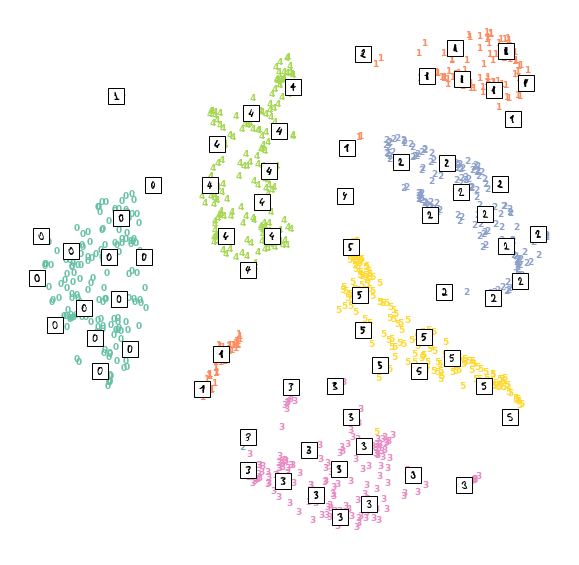

In [7]:
plot_embedding(X_tsne,y,figsize = (10,10))

In [8]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
n_eps = 6
n_min_pts = 6
eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 2
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

In [9]:
nmi_arr_db, cl_objects_db, consensus_obj_db = param_search_dbscan(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 50.0, minPts: 7
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:04.481548
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.18
Consensus clustering terminated.
Finished after 0:00:09.743432
ANMI (average normalized mutual information) of consensus with clusterings: 0.187
Calculate NMI's


Number of clusterings: 36


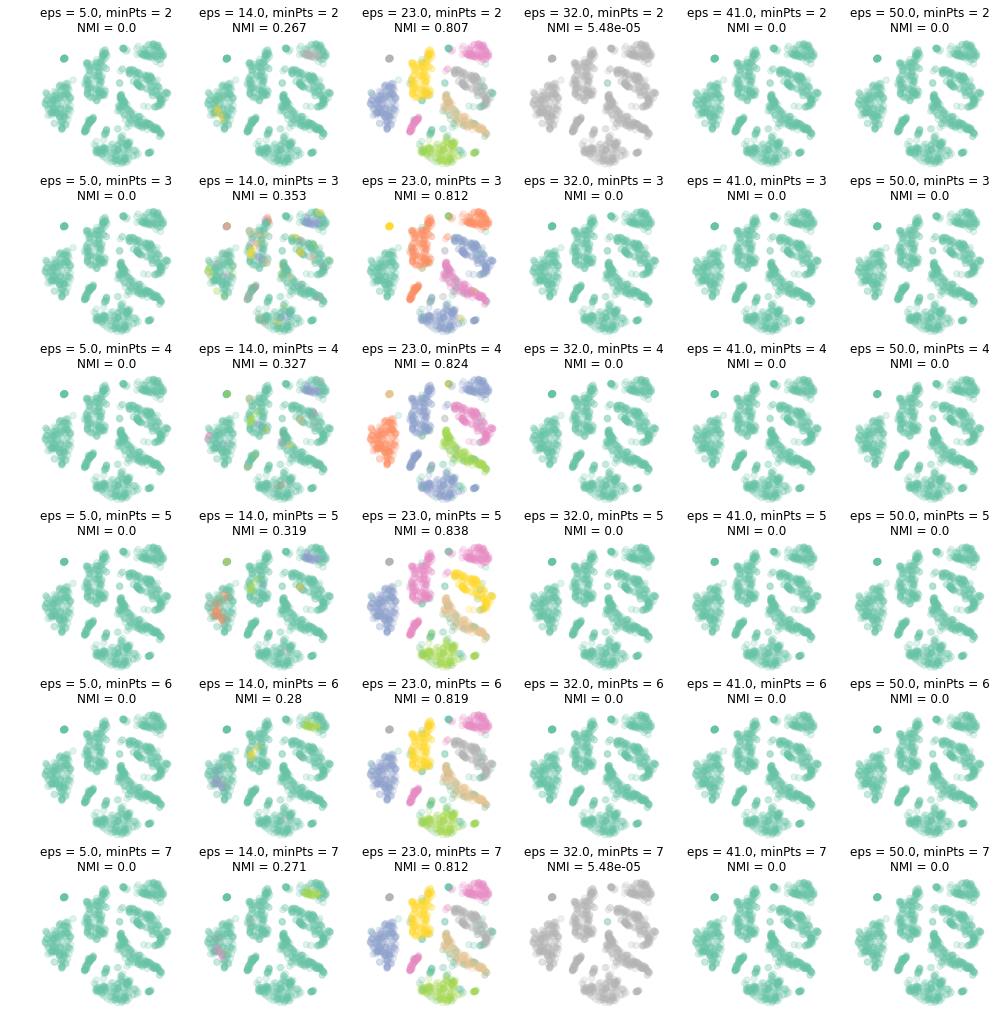

In [10]:
plot_results(data=X_tsne, cl_objects=cl_objects_db, nmi_arr=nmi_arr_db, consensus_obj=consensus_obj_db, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr,
            savetitle = 'img/mnist_dbscan_consensus.png')

## Consensus clustering result using DBSCAN vs highest NMI result with consensus

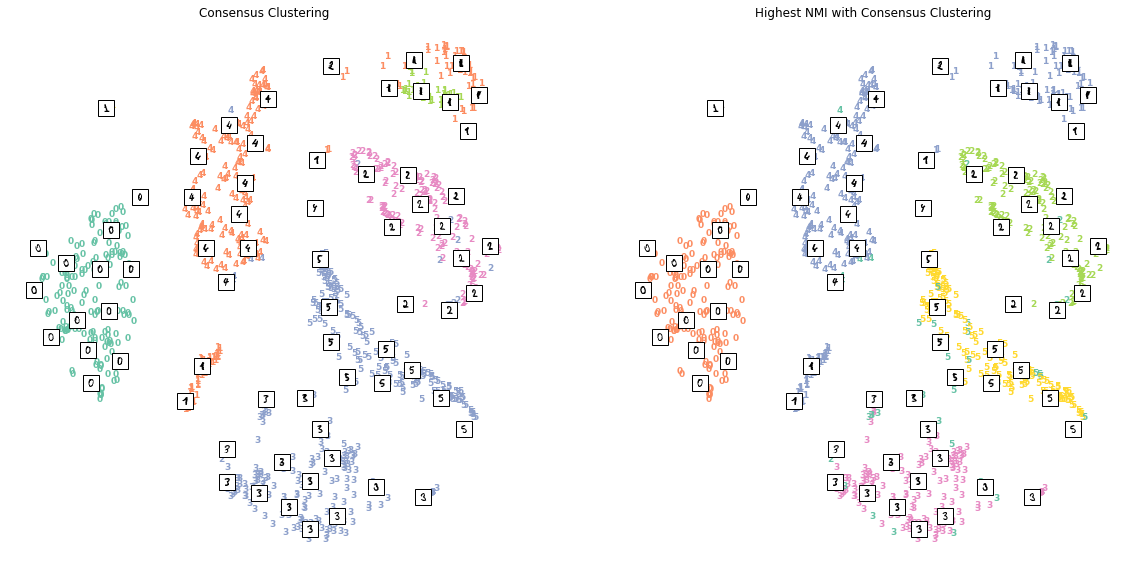

In [11]:
#highest NMI with consensus
best=np.argmax(nmi_arr_db)

obj=cl_objects_db[best]
labels_parametersearch=consensus_obj_db._noise_to_zero(obj).cluster_labels

plot_embedding_cons_par(X_tsne,consensus_obj_db.cluster_labels.astype(int),labels_parametersearch.astype(int),figsize = (20,10),savetitle = 'img/mnist_consensus_dbscan_tSNE.png')

In [12]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[best],", minpts: ", mesh_min_pts.flatten()[best])

The best parameter choice (given the chosen range) has NMI  0.837614402813  compared to the consensus result, the best parameters are then eps:  23.0 , minpts:  4


### MEANSHIFT

In [13]:
def param_search_meanshift(data, k_consensus, recluster_what, recluster_how, bandwidth_arr, mindist_arr):
    num_objects = len(bandwidth_arr)
    ms_objects = [None] * num_objects
    ms_obj = None

    print("Fit Mean Shift objects")

    #Fit Mean Shift objects
    for i, (bandwidth, mindist) in enumerate(zip(bandwidth_arr, mindist_arr)):
        sys.stdout.write('\rbandwidth: {0}, mindist: {1}'.format(bandwidth, mindist))
        ms_obj = density.MeanShift(data, bandwidth=bandwidth, mindist=mindist, verbose=False)
        ms_obj.fit()
        ms_objects[i] = ms_obj

    print("\nFit consensus")

    # Fit consensus
    clusterings = [*ms_objects]
    consensus_obj = consensus.Consensus(clusterings=clusterings, k=k_consensus, recluster_what=recluster_what, how=recluster_how, verbose=True)
    consensus_labels = consensus_obj.cluster_labels

    print("Calculate NMI's")

    # Calculate NMI's
    nmi_array = np.zeros(num_objects)
    for i, (obj, nmi) in enumerate(zip(ms_objects, nmi_array)):
        nmi_array[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels)
    
    return nmi_array, ms_objects, consensus_obj

In [14]:
# Set parameters:

# General
stride = 1
data = digits.data[::stride]
k_consensus = 6
recluster_what = 'points'
recluster_how = 'hierarchical'

# DBSCAN
#n_eps = 6
#n_min_pts = 6
#eps_arr = np.linspace(5.0, 50.0, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
#min_pts_min = 4
#min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
#mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)

n_bandwidths = 5
bw_arr = np.linspace(5, 15.0, n_bandwidths)
mindist_arr = np.linspace(0.02, 0.05, 2) #minimum distance
mesh_bw, mesh_mindist = np.meshgrid(bw_arr, mindist_arr)

In [15]:
nmi_arr_ms, cl_objects_ms, consensus_obj_ms = param_search_meanshift(
    data = data,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    bandwidth_arr = mesh_bw.flatten(),
    mindist_arr = mesh_mindist.flatten())

Fit Mean Shift objects
bandwidth: 15.0, mindist: 0.05
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:04.361278
Stopping cluster number was reached.
Current number of clusters: 6
Current minimum cluster distance: 0.44
Consensus clustering terminated.
Finished after 0:00:07.027516
ANMI (average normalized mutual information) of consensus with clusterings: 0.493
Calculate NMI's


Number of clusterings: 10


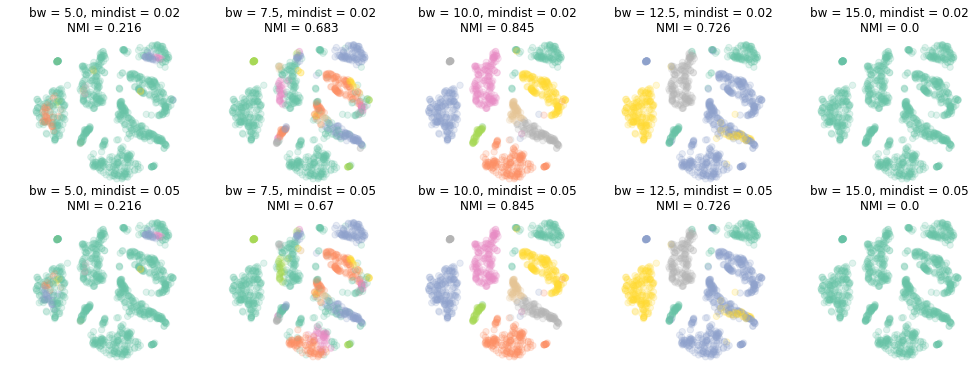

In [16]:
plot_results(data=X_tsne, cl_objects=cl_objects_ms, nmi_arr=nmi_arr_ms, consensus_obj=consensus_obj_ms, algorithm='meanshift', arr_x=bw_arr, arr_y=mindist_arr, savetitle = 'img/mnist_meanshift_consensus.png')

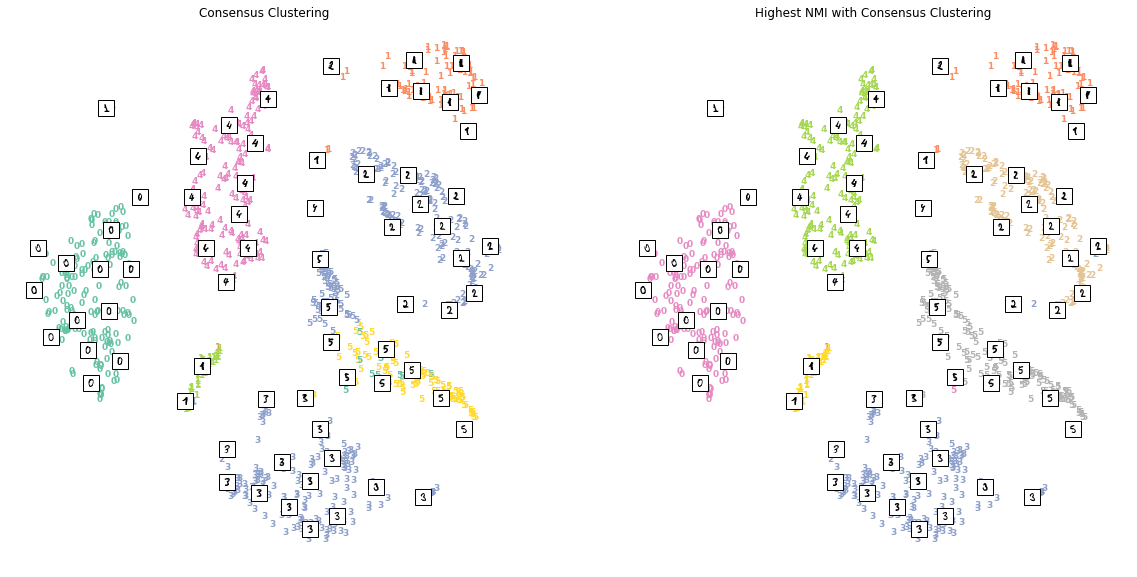

In [17]:
#highest NMI with consensus
best_ms=np.argmax(nmi_arr_ms)

obj=cl_objects_ms[best_ms]
labels_parametersearch_ms=consensus_obj_ms._noise_to_zero(obj).cluster_labels

plot_embedding_cons_par(X_tsne,consensus_obj_ms.cluster_labels.astype(int),labels_parametersearch_ms.astype(int),figsize = (20,10),savetitle = 'img/mnist_consensus_ms_tSNE.png')

In [18]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_ms), " compared to the consensus result, the best parameters are then bandwidth: ",mesh_bw.flatten()[best_ms],", mindist: ", mesh_mindist.flatten()[best_ms])

The best parameter choice (given the chosen range) has NMI  0.844513164251  compared to the consensus result, the best parameters are then bandwidth:  10.0 , mindist:  0.02


# Fuzzy Data (Synthetic)

In [19]:
def plot_synth_cons_par(X, labels_cons,labels_par, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_cons[i]),s=74,alpha=0.2)

    plt.xticks([]), plt.yticks([])

    plt.title('Consensus Clustering')   
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_par[i]),s=74,alpha=0.2)
    plt.xticks([]), plt.yticks([])
    
    plt.title('Highest NMI with Consensus Clustering')
    
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [20]:
# Set parameters:

# General
from consensus_clustering.load_data import load_fuzzy_data
fuzzy = load_fuzzy_data()
k_consensus = 10
recluster_what = 'points'
recluster_how = 'hierarchical'
save_image = True

# DBSCAN
n_eps = 6
n_min_pts = 5
eps_arr = np.linspace(0.01, 0.10, n_eps)
# min_pts = 10
# min_pts_arr = np.ones(num_objects).astype(int) * min_pts
min_pts_min = 7
min_pts_arr = np.arange(min_pts_min, min_pts_min + n_min_pts)
mesh_eps, mesh_min_pts = np.meshgrid(eps_arr, min_pts_arr)


In [21]:
nmi_arr_db_fz, cl_objects_db_fz, consensus_obj_db_fz = param_search_dbscan(
    data = fuzzy,
    k_consensus = k_consensus,
    recluster_what = recluster_what,
    recluster_how = recluster_how,
    eps_arr = mesh_eps.flatten(),
    min_pts_arr = mesh_min_pts.flatten())

Fit DBSCAN objects
eps: 0.1, minPts: 1111006, minPts: 11
Fit consensus
Hierarchical clustering terminated.
Finished after 0:00:44.386912
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.22
Consensus clustering terminated.
Finished after 0:01:05.167582
ANMI (average normalized mutual information) of consensus with clusterings: 0.277
Calculate NMI's


Number of clusterings: 30


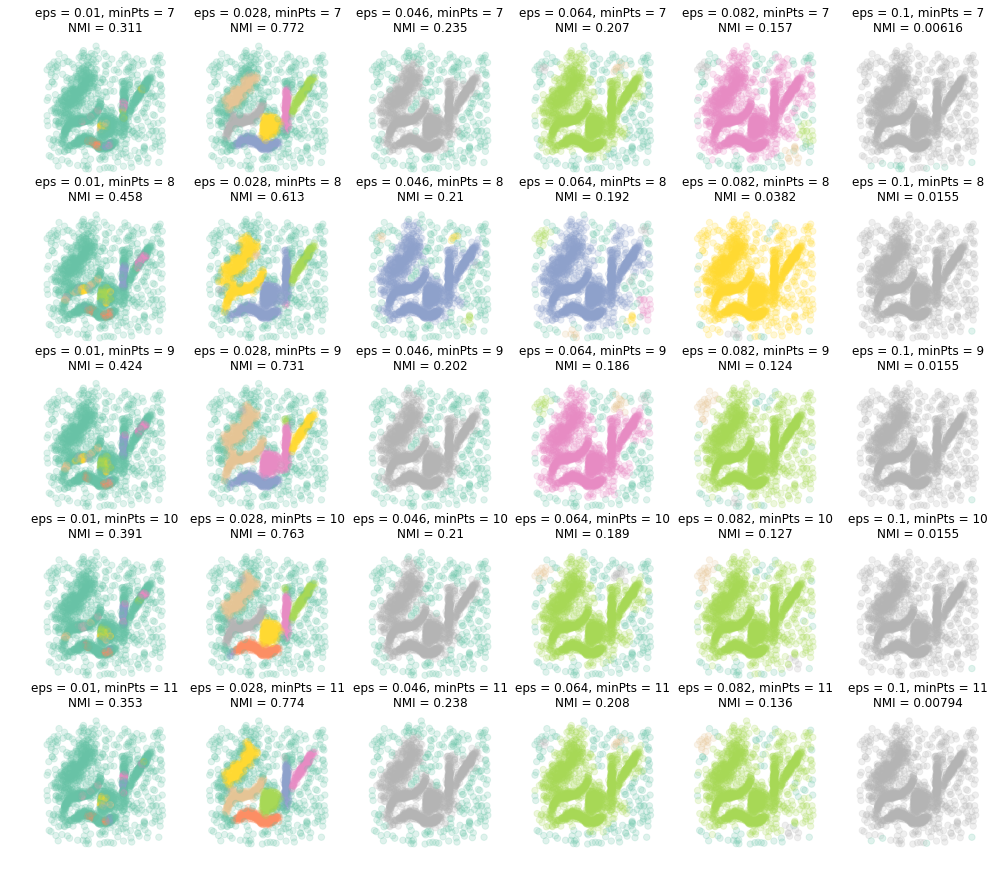

In [22]:
plot_results(data=fuzzy, cl_objects=cl_objects_db_fz, nmi_arr=nmi_arr_db_fz, consensus_obj=consensus_obj_db_fz, algorithm='dbscan', arr_x=eps_arr, arr_y=min_pts_arr, savetitle = 'img/fuzzy_dbscan_consensus.png')

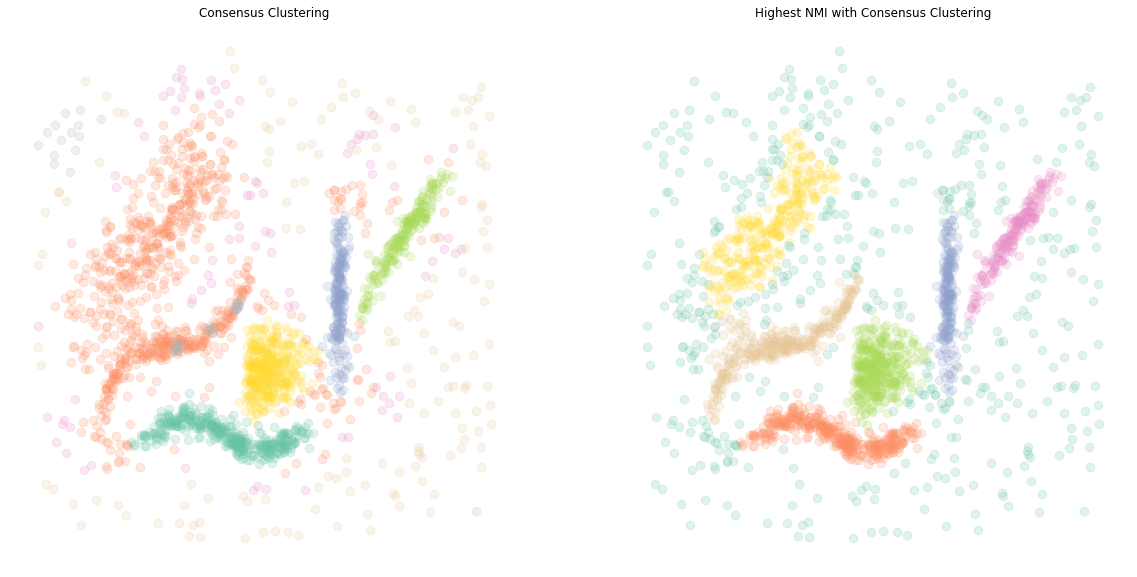

In [23]:
#highest NMI with consensus
best=np.argmax(nmi_arr_db_fz)

obj=cl_objects_db_fz[best]
labels_parametersearch_fz=consensus_obj_db_fz._noise_to_zero(obj).cluster_labels

plot_synth_cons_par(fuzzy,consensus_obj_db_fz.cluster_labels.astype(int),labels_parametersearch_fz,figsize = (20,10),savetitle = 'img/fuzzy_consensus_parametersearch.png')

In [24]:
print("The best parameter choice (given the chosen range) has NMI ", np.max(nmi_arr_db_fz), " compared to the consensus result, the best parameters are then eps: ",mesh_eps.flatten()[best],", minpts: ", mesh_min_pts.flatten()[best])

The best parameter choice (given the chosen range) has NMI  0.774296454839  compared to the consensus result, the best parameters are then eps:  0.028 , minpts:  10
